In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import numpy as np 

In [ ]:
from workflow.pipeline import culture, ephys

In [4]:
key = (ephys.QualityMetrics & 'organoid_id="O13"' & 'experiment_start_time="2023-06-08 23:35:00"').fetch("KEY")
key

[{'organoid_id': 'O13',
  'experiment_start_time': datetime.datetime(2023, 6, 8, 23, 35),
  'insertion_number': 0,
  'start_time': datetime.datetime(2023, 6, 8, 23, 59),
  'end_time': datetime.datetime(2023, 6, 9, 0, 4),
  'paramset_idx': 0}]

## Establishing threshold criteria: Initial setup for filtering metrics


In [5]:
cluster_query = (ephys.QualityMetrics.Cluster & key).proj("firing_rate","snr","presence_ratio","amplitude_cutoff","isolation_distance","l_ratio","d_prime","nn_hit_rate","nn_miss_rate")
cluster_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


### Unit restriction criteria based on brain regions


In [6]:
brain_area_unit_restrictions = {
    'Medulla': 
              # 'unit_amp > 150 '
               'firing_rate > 0.2 '
               'AND presence_ratio > 0.9 '
              #  'AND isi_violation < 10 '
               'AND amplitude_cutoff < 0.15',
    'ALM': 
            # 'unit_amp > 100 '
           'firing_rate > 0.2 '
           'AND presence_ratio > 0.95 '
          #  'AND isi_violation < 0.1 '
           'AND amplitude_cutoff < 0.1',
    'Midbrain': 
              # 'unit_amp > 100 '
                'firing_rate > 0.1 '
                'AND presence_ratio > 0.9 '
                # 'AND isi_violation < 1 '
                'AND amplitude_cutoff < 0.08',
    'Thalamus': 
              # 'unit_amp > 90 '
                'firing_rate > 0.1 '
                'AND presence_ratio > 0.9 '
                # 'AND isi_violation < 0.05 '
                'AND amplitude_cutoff < 0.08',
    'Striatum': 
              # 'unit_amp > 70 '
                'firing_rate > 0.1 '
                'AND presence_ratio > 0.9 '
                # 'AND isi_violation < 0.5 '
                'AND amplitude_cutoff < 0.1'
}


In [7]:
cluster_query & brain_area_unit_restrictions['Medulla']

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


In [8]:
cluster_query & brain_area_unit_restrictions['ALM']

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


In [9]:
cluster_query & brain_area_unit_restrictions['Midbrain']

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


In [10]:
cluster_query & brain_area_unit_restrictions['Thalamus']

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


In [11]:
cluster_query & brain_area_unit_restrictions['Striatum']

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,1.93333,3.28701,1.0,0.00161026,32.8634,0.0609784,5.36447,0.9065,5.68053e-05
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,4.64,3.52826,1.0,0.0106748,15.6642,1.62316,4.54951,0.478495,0.00042899
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,3.84333,3.40865,1.0,0.00776581,20.524,0.523946,3.83834,0.730053,0.000305748
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,14.5833,1.99025,1.0,0.0179635,80.9973,0.0281105,5.33276,0.938,0.0144192
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,14.41,2.13753,1.0,0.00551225,240.993,0.00289529,5.91164,0.988,0.031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,4.80667,3.5748,1.0,0.00179575,19.6506,0.621278,3.51957,0.658967,0.00056031
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,3.95,3.48284,1.0,0.000518913,32.8641,0.0373145,6.07524,0.95509,0.000228821
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,16.8933,1.80257,1.0,0.00259682,217.079,0.00184211,5.87884,0.9925,0.039
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,4.82667,3.49543,1.0,0.0100489,74.3011,0.00239375,5.28778,0.9455,0.0005
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,2.01333,2.61275,1.0,0.0112433,6.17729,2.44932,0.597775,0.181,0.1275


##


## Waverform post-analysis


Based on Extended Data Fig. 8 from:

- Yang, X., Forró, C., Li, T. L., Miura, Y., Zaluska, T. J., Tsai, C. T., ... & Cui, B. (2024). Kirigami electronics for long-term electrophysiological recording of human neural organoids and assembloids. Nature Biotechnology, 1-8.


In [15]:
# pip install umap-learn[plot] in the conda environment
import umap   
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [16]:
(ephys.WaveformSet.PeakWaveform & key)

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,peak_electrode_waveform (uV) mean waveform for a given unit at its representative electrode
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,0,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,1,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,2,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,3,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,4,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,5,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,6,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,7,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,8,=BLOB=
O13,2023-06-08 23:35:00,0,2023-06-08 23:59:00,2023-06-09 00:04:00,0,9,=BLOB=


In [17]:
peak_wf = (ephys.WaveformSet.PeakWaveform & key).fetch("peak_electrode_waveform")

Plot the overlay of all the detected signals:


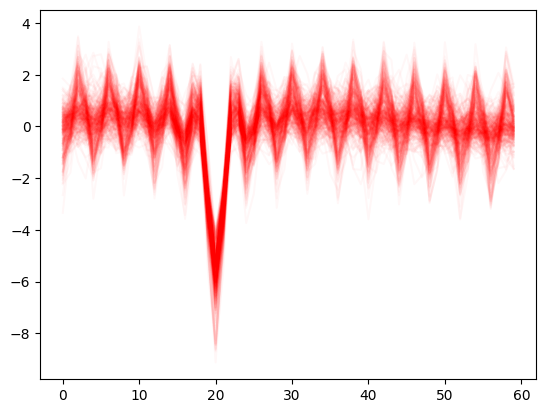

In [18]:
for wf in peak_wf:
    plt.plot(wf, color='red', alpha=0.03)

UMAP dimensionality reduction is performed on every signal into two components. Density based clustering (DBSCAN) is performed on the component space. Each detected cluster corresponds to a given signal waveform.


In [30]:
peak_wf_vs = np.vstack(peak_wf)
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.25,
                      metric='correlation').fit_transform(peak_wf_vs)

Use of the DBSCAN function to extract the clustering labels:


In [21]:
clustering = DBSCAN(eps=3, min_samples=2).fit(embedding)

Plot the results


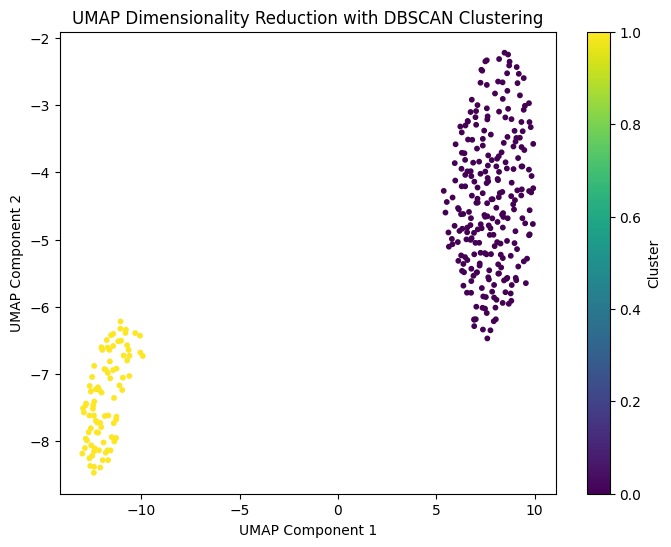

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clustering.labels_, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('UMAP Dimensionality Reduction with DBSCAN Clustering')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

Let's select one of the clusters:


In [29]:
target_cluster_label = 0
cluster_indices = np.where(clustering.labels_ == target_cluster_label)[0]
target_cluster_data = peak_wf_vs[cluster_indices]

Representative spikes are presented by averaging all the signals belonging to a given cluster:


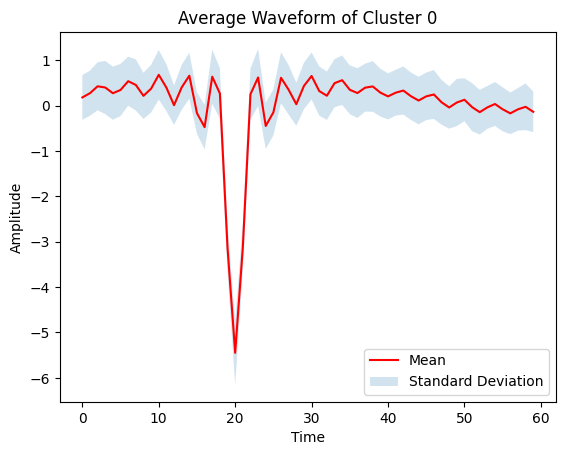

In [28]:
mean_cluster = np.mean(target_cluster_data, axis=0)
std_cluster = np.std(target_cluster_data, axis=0)

plt.plot(mean_cluster, color='red', label='Mean')
plt.fill_between(range(len(mean_cluster)), mean_cluster - std_cluster, mean_cluster + std_cluster, alpha=0.2, label='Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Average Waveform of Cluster {}'.format(target_cluster_label))
plt.legend(loc='lower right')
plt.show()